<a href="https://colab.research.google.com/github/zahidcv/OCT-Image-Denoising/blob/main/OCT_Image_Denoiser_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

My plan:



---


1. Colected Dataset from 3 sources.


2.   managed to gather total of around **45 pairs** of clean and noisy image
3.   created patch of size `64 x 64`
4.   defined 2 functions `gan-fit`(only works with gan loss) and `no-gan-fit`    only works with mse loss)

5. defined 2 functions `gan-fit`(only works with gan loss) and `no-gan-fit` (only works with mse loss)

Findings:


---


1. `No GAN` function(only mse loss) seems to work and achieved 27 PSNR


problem:

---

1. `Gan` function seem to learn nothing. The Discriminator loss become 0 and Generator loss gets sky-rocketed
2. Denoised Image is a completely black image


In [120]:
import os, shutil
from os.path import join, isdir
from os import mkdir, makedirs
import cv2
import sys
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
from timeit import default_timer as timer
from torch.utils.tensorboard import SummaryWriter

In [121]:
# Find Out if the code is running in Google Colab

COLAB = 'google.colab' in sys.modules

#setting up Device for device agnostic code

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.mps.backened.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
    
print(DEVICE)

cuda


In [122]:
if COLAB:
  if not isdir("/content/Patch OCT Dataset"):
    print("Downloading dataset")
    !pip install -U --no-cache-dir gdown --pre    
    !gdown 1q4Bm6z4xXTM2_1oIt5n3dyM0iCwPmTcI
    !unzip '/content/Patch OCT Dataset.zip'
    
    
    #   from google.colab import drive
#   drive.mount('/content/drive')
  
#   # Defining Data Path
#   Root_Dir = '/content/drive/MyDrive/Research/OCT datasets'

In [123]:
!nvidia-smi

Thu Apr 13 08:25:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |   2161MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [124]:
# Setting Specific data path for each different data folder
# first_first = os.path.join(Root_Dir,'Fast Acuisition', 'For synthetic experiments')
# first_second = os.path.join(Root_Dir,'Fast Acuisition', 'Images for Dictionaries and Mapping leraning')
# second = os.path.join(Root_Dir, 'Sparsity Based Denoising... _SDOCT_DATASET_2012_AMD')


## Importing raw images paths to `IMAGE_PATHS` list

In [125]:
# Setting Specific data path for each different data folder
# first_first = os.path.join(Root_Dir,'Fast Acuisition', 'For synthetic experiments')
# first_second = os.path.join(Root_Dir,'Fast Acuisition', 'Images for Dictionaries and Mapping leraning')
# second = os.path.join(Root_Dir, 'Sparsity Based Denoising... _SDOCT_DATASET_2012_AMD')
# IMAGE_PATHS = []


# def first_first():
# # Adding paths of the First-First Dataset
#   CLEAN_IMAGES = []
#   NOISY_IMAGES = []
#   IMAGE_PATHS = []
#   for folder in os.listdir(first_first):
#     folder_path = os.path.join(first_first, folder)

    


#     clean_img_path = join(folder_path, 'average.tif')
#     noisy_image_path = join(folder_path, '1.tif')

#     IMAGE_PATHS.append([noisy_image_path, clean_img_path, 'FAFSE'])


# # second dataset
# def second():
#   for folder in sorted(os.listdir(second)):

#     folder_path = os.path.join(second, folder)

#     if os.path.isfile(folder_path):
#       continue
    

#     for img in os.listdir(folder_path):
#       if 'Averaged' in img:

#         clean_img_path = join(folder_path, img)
#       elif 'Raw' in img:

#         noisy_image_path = join(folder_path, img)

#     IMAGE_PATHS.append([noisy_image_path, clean_img_path, 'FAIFD'])



# # First Second
# def First_Second():
#   for i in range(1,11):
#     clean_image_path = join(first_second, f'HH{i}.tif')

#     noisy_image_path = join(first_second, f'LL{i}.tif')

#     IMAGE_PATHS.append([noisy_image_path, clean_image_path, 'SBD'])



### deleting contents of a folder

In [126]:
import os, shutil
def del_contents(path):
  folder = path
  for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))

## Saving Images in a single folder

In [127]:
# # Saving Images in a single folder
# root_dir = '/content/drive/MyDrive/Research/OCT datasets/Organised Dataset'
# dir = root_dir
# if isdir(root_dir):
#   del_contents(root_dir)
# else:
#   mkdir(root_dir)
# clean_dir = join(root_dir, 'Clean')
# noisy_dir = join(root_dir, 'Noisy')

# if not os.path.isdir(clean_dir):
#   os.mkdir(clean_dir)
#   os.mkdir(noisy_dir)

# index = 1
# for n,c,ds in IMAGE_PATHS:

#   folder_name = f"{index:03d} {ds}"

#   clean_folder_path = join(clean_dir, folder_name)

#   if not os.path.isdir(clean_folder_path):
#     os.mkdir(clean_folder_path)

#   file_name = f"{index:03d} {ds}.jpg"
#   clean_image_path = join(clean_folder_path, file_name)
#   shutil.copy(c, clean_image_path)

#   ######################

#   noisy_folder_path = join(noisy_dir, folder_name)

#   if not os.path.isdir(noisy_folder_path):
#     os.mkdir(noisy_folder_path)

#   file_name = f"{index:03d} {ds}.jpg"
#   noisy_image_path = join(noisy_folder_path, file_name)
#   shutil.copy(n, noisy_image_path)


#   index+=1

  

In [128]:
# len(IMAGE_PATHS)

## Creating Image Patchs

In [129]:
# Creating Image Paths

PATCH_SIZE = 64

patch_root_dir = "/content/drive/MyDrive/Research/OCT datasets/Patch OCT Dataset"
def create_patch(patch_size = 64, dest_dir = patch_root_dir):

  #Check if the dest_dir is already availabe, if so, delete it otherwise create
  if isdir(patch_root_dir):
    del_contents(patch_root_dir)
  else:
    os.mkdir(patch_root_dir)


  #setting the different paths for clean and Noisy patch
  clean_patch_dir = join(patch_root_dir, 'Clean')
  noisy_patch_dir = join(patch_root_dir, 'Noisy')

  if not isdir(clean_patch_dir):
    makedirs(clean_patch_dir)
    makedirs(noisy_patch_dir)


  patch_list = []

  #setting the different paths for raw images
  clean_raw_image_dir = '/content/drive/MyDrive/Research/OCT datasets/Organised Dataset/Clean'
  noisy_raw_image_dir = '/content/drive/MyDrive/Research/OCT datasets/Organised Dataset/Noisy'


  for folder in sorted(os.listdir(clean_raw_image_dir)):
    clean_image_path = join(clean_raw_image_dir, folder, folder+'.jpg')
    noisy_image_path = join(noisy_raw_image_dir, folder, folder+'.jpg')

    clean_image = cv2.imread(clean_image_path,0)
    noisy_image = cv2.imread(noisy_image_path, 0)

    if(clean_image.shape != noisy_image.shape):
      print(f"Shape mismatch {clean_image.shape} - {noisy_image.shape} - {folder}")

    height, width = clean_image.shape

    clean_patch_folder_path = join(clean_patch_dir, folder)
    noisy_patch_folder_path = join(noisy_patch_dir, folder)
    mkdir(clean_patch_folder_path)
    mkdir(noisy_patch_folder_path)
    
    index = 1
    for h in range(height//PATCH_SIZE):
      # print(i)
      for w in range(width//PATCH_SIZE):
        # print(f"j = {j}")
        clean_patch = clean_image[h*PATCH_SIZE:(h+1)*PATCH_SIZE , w*PATCH_SIZE:(w+1)*PATCH_SIZE , ]
        clean_patch_image_path = join(clean_patch_folder_path, f"{index:03d}.jpg")
        cv2.imwrite(clean_patch_image_path, clean_patch)
        ######################
        noisy_patch = noisy_image[h*PATCH_SIZE:(h+1)*PATCH_SIZE , w*PATCH_SIZE:(w+1)*PATCH_SIZE , ]
        noisy_patch_image_path = join(noisy_patch_folder_path, f"{index:03d}.jpg")
        cv2.imwrite(noisy_patch_image_path, noisy_patch)

        # print(clean_patch_image_path, noisy_patch_image_path)


      patch_list.append([noisy_patch, clean_patch])
      index+=1

      # plt.subplot(1,2,1)
      # plt.imshow(noisy_patch, cmap='gray')
      # plt.subplot(1,2,2)
      # plt.imshow(clean_patch, cmap='gray')
  #     break
  #   break
  # break

 

In [130]:
def de_patch():
  pass
  

# Loading dataset

In [131]:
if COLAB:
    patch_data_dir = '/content/Patch OCT Dataset'
elif DEVICE == 'mps':
    pass
else:
    patch_data_dir = r"C:\Users\HP\Documents\Zahid\OCT\DATASET\Patch OCT Dataset"


clean_data_dir = join(patch_data_dir, 'Clean')
noisy_data_dir = join(patch_data_dir, 'Noisy')
IMAGE_PATHS = []

for folder in sorted(os.listdir(clean_data_dir)):
    
    if folder[0] == '.':
        continue
    
    clean_folder_path = join(clean_data_dir, folder)
    noisy_folder_path = join(noisy_data_dir, folder)
    # print(current_folder_path)
    for img in sorted(os.listdir(clean_folder_path)):
        if img[0] == '.':
            continue
        # print(img)

        clean_img_path = join(clean_folder_path, img)
        noisy_img_path = join(noisy_folder_path, img)

        IMAGE_PATHS.append([noisy_img_path, clean_img_path])
        # print(clean_img_path, noisy_img_path)





In [132]:
len(IMAGE_PATHS)

4708

#  Datasets and Dataloaders

## Creating Dataset

### Custom Dataset Class

In [133]:
class CustomDataset(Dataset):

  def __init__(self, paths, transform = None):
    self.paths = paths
    self.transform = transform

  def __getitem__(self, index:int, ):

    noisy_img = Image.open(self.paths[index][0])
    clean_img = Image.open(self.paths[index][1])
    # clean_img = transforms.functional.adjust_sharpness(clean_img,sharpness_factor=10)

    if self.transform:
      return self.transform(noisy_img), self.transform(clean_img)

    return noisy_img, clean_img



  def __len__(self):
    return len(self.paths)



### Transformations

In [134]:
# defining Transforms Needed to be done on the Images
trans = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.Resize((128,128)),

    transforms.ToTensor(),
    # transforms.Normalize((0.5), (0.5))
])

### Dataset Instance

In [135]:
# Dataset 
dataset = CustomDataset(IMAGE_PATHS, transform = trans)
len(dataset)

4708

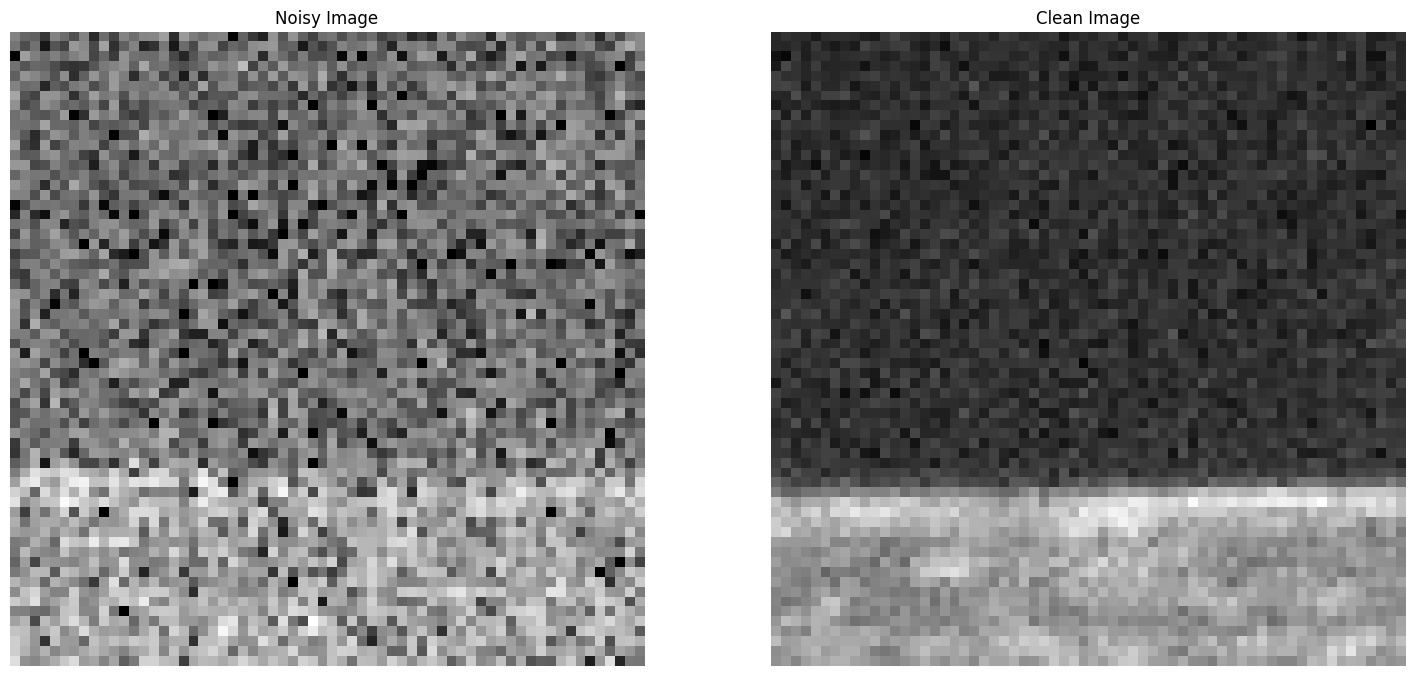

In [136]:
plt.figure(figsize = (18,18))
plt.subplot(1,2,1)
plt.imshow(dataset[1][0].squeeze(), cmap = 'gray')
plt.title('Noisy Image')
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(dataset[1][1].squeeze(), cmap = 'gray')
plt.title('Clean Image')
plt.axis("off")

n,c = dataset[1][0], dataset[1][1]

## BATCH SIZE

In [137]:
BATCH_SIZE = 32

## Data Loader

In [138]:
start_time = timer()
r = torch.tensor([32,1,64,64], device = DEVICE)
print(timer()-start_time)

0.0005134590001034667


In [139]:
train_dl = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True,)


# Model Creation and Training Testing

## Generator Model

In [140]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # decoder layers
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
        nn.Sigmoid()
    )


    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      module.weight.data.normal_(mean=0.0, std=1.0)
      if module.bias is not None:
          module.bias.data.zero_()



  def forward(self, x):
    encoded = self.encoder(x)

    # print(f"Shape of encoded: {encoded.shape}")
    decoded = self.decoder(encoded)
    return decoded

In [141]:
# import torch
# import torch.nn as nn

# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()

#         # Define the encoder layers
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, 3, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(16, 32, 3, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(32, 64, 3, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 128, 3, stride=2, padding=1),
#             nn.ReLU(inplace=True)
#         )

#         # Define the decoder layers
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         # Define the forward pass
#         encoded = self.encoder(x)
        
#         # The output shape of the encoder should be [batch_size, 128, 4, 4]
#         # If the input shape is [batch_size, 1, 64, 64]
#         # Reshape the output of the encoder to match the shape of the input
#         encoded = encoded.view(x.size(0), 128, 4, 4)
        
#         print(f"Shape of encoded: {encoded.shape}")
#         # Add the residual connection by adding the input to the output of the decoder
#         decoded = self.decoder(encoded) + x

#         print(f"Shape of encoded: {encoded.shape}")
        
#         return decoded


# rand_img = torch.randn([32, 1, 64, 64])
# print(f"Random Image shape: {rand_img.shape}")
# # print()
# generator = Generator()

# result = generator(rand_img)

### Test Generator Model

In [142]:
rand_img = torch.rand([32, 1, 64, 64])
print(f"Random Image shape: {rand_img.min()}")
# print()
generator = Generator()

result = generator(rand_img)

Random Image shape: 3.5762786865234375e-07


torch.Size([1, 1, 64, 64])


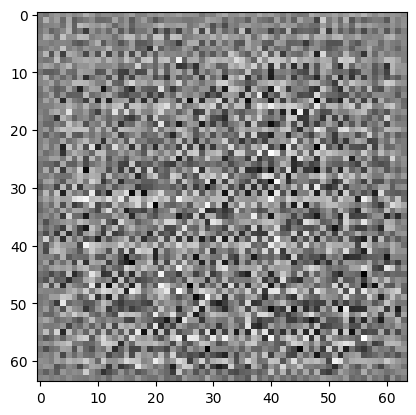

In [143]:
generator = Generator().to(DEVICE)

x = n.unsqueeze(dim=1)

result = generator(x.to(DEVICE))
print(result.shape)
with torch.inference_mode():
  plt.imshow(result.squeeze().to('cpu'), cmap='gray')

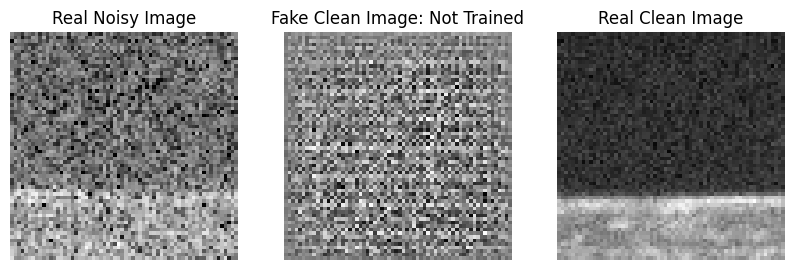

In [144]:
test_noisy_image = n.to(DEVICE)
gen_clean_image = generator(test_noisy_image.unsqueeze(dim=1)).squeeze()
real_clean_image = c


fig = plt.figure(figsize = (10,10))
with torch.inference_mode():
  fig.add_subplot(1,3,1)
  plt.imshow(test_noisy_image.squeeze().to('cpu'), cmap='gray')
  plt.title("Real Noisy Image")
  plt.axis('off')

  fig.add_subplot(1,3,2)
  plt.imshow(gen_clean_image.to('cpu'), cmap='gray')
  plt.title("Fake Clean Image: Not Trained")
  plt.axis('off')

  fig.add_subplot(1,3,3)
  plt.imshow(real_clean_image.squeeze().to('cpu'), cmap='gray')
  plt.title("Real Clean Image")
  plt.axis('off')

## Discriminitor 

In [145]:
class Discriminator(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()

    self.block_1 = nn.Sequential(
        
        nn.Conv2d(
            in_channels = input_shape, 
            out_channels = 64,
            kernel_size = 3,
            # padding=1,
            # stride=1,
        ),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),

        # 
        # nn.Conv2d(
        #     in_channels = 64, 
        #     out_channels = 128,
        #     kernel_size = 3,
        #     # padding=1,
        #     # stride=1,

        # ),
        # nn.BatchNorm2d(128),
        # nn.ReLU(),

        # nn.MaxPool2d(
        #     kernel_size = 2,
        #     # stride=2,
        # ),
        # 

#         nn.Conv2d(
#             in_channels = 128, 
#             out_channels = 256,
#             kernel_size = 3,
#             # padding=1,
#             # stride=1,

#         ),
#         nn.BatchNorm2d(256),
#         nn.ReLU(),

#         nn.MaxPool2d(
#             kernel_size = 2,
#             # stride=2,
#         ),
#         # 

#         nn.Conv2d(
#             in_channels = 256, 
#             out_channels = 512,
#             kernel_size = 3,
#             # padding=1,
#             # stride=1,

#         ),
#         nn.BatchNorm2d(512),
#         nn.ReLU(),

#         nn.MaxPool2d(
#             kernel_size = 2,
#             # stride=2,
#         ),


    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 64*31*31, out_features = 256),
        nn.ReLU(),
        nn.Linear(in_features = 256, out_features = output_shape)

    )
  
  def forward(self, x):
    x = self.block_1(x)

    # print(x.shape)
    x = self.classifier(x)

    return x





### Test Discriminator

In [146]:
# Test Discriminator
discriminator = Discriminator(1,1).to(DEVICE)
x = torch.rand(size = [20,1,64,64]).to(DEVICE)

r = discriminator(x)
print(r.shape)


torch.Size([20, 1])


## Hyperparameters

In [147]:
mse_loss = nn.MSELoss()
bceloss = nn.BCEWithLogitsLoss()


optim_d = torch.optim.Adam(discriminator.parameters(), lr = 0.01, weight_decay=1e-5)
optim_g = torch.optim.Adam(generator.parameters(), lr = 0.0001, weight_decay=1e-5)


"""
Findings:
1. Learning rate >= 0.1 gives poor performance
2. Learning rate = 0.001 and w_d = 1e-4 has good start but eventually performs worse. 
3. Learning rate = 0.01 and w_d = 1e-5 has performs worse performance than 2.
3. Learning rate = 0.0001 and w_d = 1e-5 has performs the best so far.
"""


'\nFindings:\n1. Learning rate >= 0.1 gives poor performance\n2. Learning rate = 0.001 and w_d = 1e-4 has good start but eventually performs worse. \n3. Learning rate = 0.01 and w_d = 1e-5 has performs worse performance than 2.\n3. Learning rate = 0.0001 and w_d = 1e-5 has performs the best so far.\n'

## Util Functions

### Show sample

In [148]:
def show_sample():
  test_noisy_image = n.to(DEVICE)
  gen_clean_image = generator(test_noisy_image.unsqueeze(dim=1)).squeeze()
  real_clean_image = c

  fig = plt.figure(figsize = (10,10))

  with torch.inference_mode():
    fig.add_subplot(1,3,1)
    plt.imshow(test_noisy_image.squeeze().to('cpu'), cmap='gray')
    plt.title("Real Noisy Image")
    plt.axis('off')

    fig.add_subplot(1,3,2)
    plt.imshow(gen_clean_image.to('cpu'), cmap='gray')
    plt.title("Fake Clean Image")
    plt.axis('off')

    fig.add_subplot(1,3,3)
    plt.imshow(real_clean_image.squeeze(), cmap='gray')
    plt.title("Real Clean Image")
    plt.axis('off')

    plt.show()

### PSNR calculation

In [149]:
from math import log10,sqrt
def PSNR(original, compressed):
    mse = torch.mean((torch.sub(original, compressed)) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = torch.max(original)
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

## Train Step

### Discriminator Trainer

In [150]:
import torch.nn.functional as F


def train_discriminator(noisy_images, clean_images, optimizer_d):
  optimizer_d.zero_grad()

  preds_for_real = discriminator(clean_images)
  targets_for_real = torch.ones(clean_images.size(0), 1, device = DEVICE)
  
  loss_for_real = bceloss(preds_for_real, targets_for_real)
  real_score = torch.mean(preds_for_real).item()



  fake_clean_images = generator(noisy_images)


  preds_for_fake = discriminator(fake_clean_images)
  targets_for_fake = torch.zeros(fake_clean_images.size(0), 1, device = DEVICE)

  loss_for_fake = bceloss(preds_for_fake, targets_for_fake)

  fake_score = torch.mean(preds_for_fake).item()

  # diff_in_images = mseloss(clean_images, fake_clean_images)
  # writer.add_scalar('Diff in Image', diff_in_images )
  # print(f"Disc Diff in Images: {diff_in_images}")

  loss = loss_for_real + loss_for_fake 
  # print(diff_in_images, loss_for_real, loss_for_fake)
  
  loss.backward()

  optimizer_d.step()

  return loss.item(), real_score, fake_score




### Generator Trainer

In [162]:
mse_loss = nn.MSELoss()
def train_generator(noisy_images, real_images, optimizer_g):

  fake_images = generator(noisy_images)
  with torch.inference_mode():
    preds_for_fake = discriminator(fake_images)

  false_targets_for_fake = torch.ones(fake_images.size(0), 1, device = DEVICE)

  # diff_in_images = mseloss(real_images, fake_images)
  # print(f"Diff in Images: {diff_in_images}")
  g_loss_bce = bceloss(preds_for_fake, false_targets_for_fake)

  g_loss_mse = mse_loss(fake_images, real_images)

  # Extract VGG features
  fake_features = vgg_features(fake_images)

  real_features = vgg_features(real_images)
  g_loss_perceptual = mse_loss(fake_features, real_features)
  
  g_loss = g_loss_bce + 0.1 * g_loss_mse + 0.01 * g_loss_perceptual
  print(f"g_loss, g_loss_bce, g_loss_mse, g_loss_perceptual --> {g_loss:.4f}, {g_loss_bce:.4f}, {g_loss_mse:.4f},{g_loss_perceptual:.4f}")
  # generator_loss.backward()


  optimizer_g.zero_grad()
  g_loss.backward()
  optimizer_g.step()

  return g_loss.item()

## Tensorboards Setup


In [163]:
name = input("Name the Experiment: ")
writer = SummaryWriter(f'runs/OCT Denoise/{name}')

Name the Experiment: perceptual 1, 0.1, 0.01, lr o.0001


## Fit Function

In [164]:
from tqdm.notebook import tqdm
Images = []
def gan_fit(EPOCHS, start_idx= 1):
  torch.cuda.empty_cache()

  Gen_Loss = []
  Dis_Loss = []

  Real_Scores = []
  Fake_Scores = []

  for epoch in tqdm(range(EPOCHS)):

    for noisy_images, clean_images in tqdm(train_dl):
      noisy_images = noisy_images.to(DEVICE,)
      clean_images = clean_images.to(DEVICE,)

      loss_d, real_score, fake_score = train_discriminator(noisy_images, clean_images, optim_d)
      loss_g = train_generator(noisy_images, clean_images, optim_g)
      
      #forward Pass
        

        
        
      #Backward Pass


      Gen_Loss.append(loss_g)
      Dis_Loss.append(loss_d)
      writer.add_scalar('Disc LOSS', loss_d, global_step = epoch+1)
      writer.add_scalar('Gen LOSS', loss_g, global_step = epoch+1)
   

#       Real_Scores.append(real_score)
#       Fake_Scores.append(fake_score)

    # show_sample()
      test_noisy_image = n.to(DEVICE)
      gen_clean_image = generator(test_noisy_image.unsqueeze(dim=1)).squeeze()
      real_clean_image = c.to(DEVICE)

      psnr_before = PSNR(real_clean_image, test_noisy_image)
      psnr_after= PSNR(real_clean_image, gen_clean_image)
      # writer.add_scalar('PSNR', psnr, global_step = epoch+1)
      writer.add_scalar('PSNR with Noisy', psnr_before, global_step = epoch+1)
      writer.add_scalar('PSNR with Resultant clean', psnr_after, global_step = epoch+1)
      writer.add_image('Fake Clean Image', gen_clean_image, dataformats='HW')
      Images.append([test_noisy_image.to('cpu'),gen_clean_image.to('cpu'), real_clean_image])
    
    print(f"EPOCH: {epoch+1} | Gen Loss: {loss_g:.4f} |  Dis Loss: {loss_d:.4f} | PSNR: {psnr_before:.4f}-->{psnr_after:.4f} \n\n")

    # save_samples(epoch+start_idx, fixed_latent, show = False)
  
  return Gen_Loss, Dis_Loss, Real_Scores, Fake_Scores


## No GAN

In [165]:
from tqdm.notebook import tqdm
# Images = []
all_loss = []
def no_gan_fit(EPOCHS, start_idx= 1):
  torch.cuda.empty_cache()

  for epoch in range(EPOCHS):
    
    for noisy_images, clean_images in train_dl:
      noisy_images = noisy_images.to(DEVICE,)
      clean_images = clean_images.to(DEVICE,)
      
      #forward Pass
        
      optim_g.zero_grad()

      res = generator(noisy_images)
      psnr_before = PSNR(clean_images, noisy_images)
      psnr_after = PSNR(clean_images, res)
      loss = mseloss(res, clean_images)
        
        
      #Backward Pass
      loss.backward()
      optim_g.step()
      
        
    
      writer.add_scalar('MSE LOSS', loss.item(), global_step = epoch+1)
      writer.add_scalar('PSNR with Noisy', psnr_before, global_step = epoch+1)
      writer.add_scalar('PSNR with Resultant clean', psnr_after, global_step = epoch+1)

    print(f"EPOCH: {epoch+1} | MSE Loss: {loss.item():.4f} | PSNR: {psnr_before:.4f}-->{psnr_after:.4f}")
    
  
  return loss.item()


In [166]:
# testing PSNR for random image
PSNR(torch.rand([32,1,64,64]),torch.rand([32,1,64,64]))


7.775882953940343

## Wrapper

In [167]:
vgg = models.vgg16(pretrained=True)
vgg.to(DEVICE)
vgg_features = vgg.features[:23].eval()
vgg_features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
print(vgg_features)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [168]:
e = int(input("Enter EPOCHS:"))
EPOCHS = e
from timeit import default_timer as timer

start_time = timer()
history = gan_fit(EPOCHS)
end_time = timer()

print(f"\nTotal Time Taken: {(end_time-start_time)/60} minutes")


Enter EPOCHS:100


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

RuntimeError: ignored

## Performance Evaluation

In [ ]:
show_sample()

In [ ]:
# plt.figure(figsize=(15, 12))
# plt.suptitle("Noisy-Fake-Clean", fontsize=18, y=0.95)
# cols = 3
# rows = EPOCHS
# with torch.inference_mode():
#   index = 1
#   for i in range(rows*cols):
#     for j in range(3):
#       if index>rows*cols:
#         break
#       plt.subplot(rows,cols,index) 
#       plt.imshow(Images[i][j].squeeze().to('cpu'), 'gray')
#       index+=1


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs

In [ ]:
# history

In [ ]:
# from torch.profiler import profile, record_function, ProfilerActivity
# import torch
# import torchvision.models as models
# model = models.resnet18()
# inputs = torch.randn(5, 3, 224, 224)
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CPU], record_shapes=True) as prof:
#   with record_function("model_inference"):
#     model(inputs)

# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [ ]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [ ]:
fi = torch.rand([32,1,64,64])
rgb_image = fi.repeat(1, 3, 1, 1)
print(fi.shape)
vgg_features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
print(vgg_features)
fake_features = vgg_features(fi)
print(fake_features.shape)

In [ ]:
plt.imshow(fi[0].squeeze())

In [ ]:
fi